<a href="https://colab.research.google.com/github/Ilham-Putra12/KlasifikasiBeritaHoaks/blob/main/KlasifikasiBeritaHoaks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("TensorFlow Version:", tf.__version__)
print("GPU Tersedia:", tf.config.list_physical_devices('GPU'))


TensorFlow Version: 2.18.0
GPU Tersedia: []


In [9]:
data = {
    'text': [
        "Jokowi membagikan hadiah kepada seluruh rakyat Indonesia secara cuma-cuma.", # HOAX
        "Breaking News: Vaksin COVID-19 ternyata mengandung microchip.", # HOAX
        "Ilmuwan menemukan obat mujarab untuk semua penyakit kronis.", # HOAX
        "Pemerintah akan menaikkan gaji ASN sebesar 200% tahun depan.", # HOAX
        "Fakta: Presiden Republik Indonesia mengunjungi korban bencana alam di daerah terpencil.", # ASLI
        "Hoax: Gempa bumi besar akan melanda Jakarta besok pagi.", # HOAX
        "Analisis: Inflasi global diprediksi akan meningkat di kuartal berikutnya.", # ASLI
        "Berita: Timnas sepak bola Indonesia berhasil lolos ke Piala Dunia.", # HOAX (contoh, tergantung konteks)
        "Informasi: Pendaftaran CPNS tahun ini akan dibuka bulan depan.", # ASLI
        "Waspada: Modus penipuan baru melalui SMS yang mengatasnamakan bank.", # ASLI
        "Klarifikasi: Video viral tentang alien mendarat di bumi adalah editan.", # ASLI
        "Update: Proyek pembangunan infrastruktur baru di ibu kota terus berjalan.", # ASLI
        "Peringatan: Jangan pernah memberikan informasi pribadi kepada orang tak dikenal.", # ASLI
        "Riset: Penemuan baru dalam pengobatan kanker memberikan harapan.", # ASLI
        "Hoax: Matahari akan terbit dari barat pada tahun 2025.", # HOAX
        "Berita Terkini: Perusahaan teknologi raksasa meluncurkan produk inovatif.", # ASLI
        "Edukasi: Pentingnya menjaga kebersihan lingkungan untuk kesehatan.", # ASLI
        "Kontroversi: Kebijakan baru pemerintah menuai pro dan kontra di masyarakat.", # ASLI
        "Peringatan Dini: Cuaca ekstrem diperkirakan terjadi di beberapa wilayah.", # ASLI
        "Fakta: Jumlah kasus positif COVID-19 menunjukkan penurunan signifikan." # ASLI
    ],
    'label': [
        'hoax', 'hoax', 'hoax', 'hoax', 'asli',
        'hoax', 'asli', 'hoax', 'asli', 'asli',
        'asli', 'asli', 'asli', 'asli', 'hoax',
        'asli', 'asli', 'asli', 'asli', 'asli'
    ]
}

df = pd.DataFrame(data)

# Konversi label string ke numerik
# 1 untuk 'hoax', 0 untuk 'asli'
df['label'] = df['label'].apply(lambda x: 1 if x == 'hoax' else 0)

print("\n--- Contoh Data (5 baris pertama) ---")
print(df.head())
print("\n--- Distribusi Label ---")
print(df['label'].value_counts())



--- Contoh Data (5 baris pertama) ---
                                                text  label
0  Jokowi membagikan hadiah kepada seluruh rakyat...      1
1  Breaking News: Vaksin COVID-19 ternyata mengan...      1
2  Ilmuwan menemukan obat mujarab untuk semua pen...      1
3  Pemerintah akan menaikkan gaji ASN sebesar 200...      1
4  Fakta: Presiden Republik Indonesia mengunjungi...      0

--- Distribusi Label ---
label
0    13
1     7
Name: count, dtype: int64


In [10]:
vocab_size = 5000     # Ukuran vocabulary (jumlah kata unik maksimum yang akan dipertimbangkan)
embedding_dim = 100   # Dimensi vektor embedding untuk setiap kata
max_length = 100      # Panjang maksimum setiap teks (setelah padding/truncating)
trunc_type = 'post'   # Pemotongan jika teks terlalu panjang (dari akhir)
padding_type = 'post' # Padding jika teks terlalu pendek (di akhir)
oov_tok = "<OOV>"     # Token untuk kata-kata "Out Of Vocabulary"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(df['text'])
word_index = tokenizer.word_index
print(f"\nJumlah kata unik dalam vocabulary: {len(word_index)}")

# Konversi teks menjadi urutan angka (indeks kata)
sequences = tokenizer.texts_to_sequences(df['text'])

# Melakukan padding agar semua urutan memiliki panjang yang sama
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Siapkan fitur (X) dan label (y) untuk model
X = padded_sequences
y = df['label'].values


Jumlah kata unik dalam vocabulary: 153


In [11]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Kemudian, pisahkan data training (75% dari X_train_val) dan validasi (25% dari X_train_val)
# Ini menghasilkan 60% training dan 20% validasi dari total data awal (0.75 * 0.8 = 0.6)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val
)

print(f"\nUkuran Data Training: {X_train.shape[0]} samples")
print(f"Ukuran Data Validasi: {X_val.shape[0]} samples")
print(f"Ukuran Data Testing: {X_test.shape[0]} samples")


Ukuran Data Training: 12 samples
Ukuran Data Validasi: 4 samples
Ukuran Data Testing: 4 samples


In [12]:
model = Sequential([
    # Layer Embedding: Mengubah indeks kata menjadi vektor padat
    # input_dim = vocab_size (jumlah kata unik yang dipertimbangkan)
    # output_dim = embedding_dim (dimensi vektor embedding)
    # input_length = max_length (panjang urutan input)
    Embedding(vocab_size, embedding_dim, input_length=max_length),

    # Conv1D Layer: Melakukan konvolusi pada urutan.
    # 128: Jumlah filter (detektor fitur)
    # 5: Ukuran kernel (windows yang bergerak di sepanjang urutan)
    # activation='relu': Fungsi aktivasi ReLU
    Conv1D(128, 5, activation='relu'),

    # GlobalMaxPooling1D Layer: Mengambil nilai maksimum dari semua fitur yang diekstraksi
    # di sepanjang setiap filter. Ini membantu menangkap fitur yang paling signifikan.
    GlobalMaxPooling1D(),

    # Dense Layer (Fully Connected): Lapisan terhubung penuh.
    # 64: Jumlah neuron di lapisan ini
    # activation='relu': Fungsi aktivasi ReLU
    Dense(64, activation='relu'),

    # Dropout Layer: Secara acak menonaktifkan sebagian neuron selama pelatihan
    # untuk mencegah overfitting (model terlalu hafalan pada data training).
    # 0.5: Tingkat dropout (50% neuron dinonaktifkan secara acak)
    Dropout(0.5),

    # Output Layer: Lapisan terakhir untuk klasifikasi.
    # 1: Jumlah neuron (karena ini klasifikasi biner: hoax atau asli)
    # activation='sigmoid': Fungsi aktivasi Sigmoid, menghasilkan probabilitas antara 0 dan 1
    Dense(1, activation='sigmoid')
])

# Mengkompilasi model: Menentukan optimizer, fungsi loss, dan metrik
model.compile(optimizer='adam',           # Optimizer Adam adalah pilihan umum yang baik
              loss='binary_crossentropy', # Fungsi loss untuk klasifikasi biner
              metrics=['accuracy'])       # Metrik yang akan dipantau selama pelatihan

model.summary() # Menampilkan ringkasan arsitektur model

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [13]:
num_epochs = 15 # Jumlah epoch (berapa kali seluruh dataset training dilewatkan ke model)
batch_size = 32 # Ukuran batch (jumlah sampel yang diproses sebelum bobot diperbarui)

print(f"\n--- Memulai Pelatihan Model ({num_epochs} Epochs) ---")
history = model.fit(
    X_train, y_train,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    verbose=1 # Menampilkan progress pelatihan
)


--- Memulai Pelatihan Model (15 Epochs) ---
Epoch 1/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.5000 - loss: 0.6967 - val_accuracy: 0.7500 - val_loss: 0.6828
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.6667 - loss: 0.6649 - val_accuracy: 0.7500 - val_loss: 0.6750
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step - accuracy: 0.7500 - loss: 0.6633 - val_accuracy: 0.7500 - val_loss: 0.6702
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step - accuracy: 0.7500 - loss: 0.6518 - val_accuracy: 0.7500 - val_loss: 0.6680
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.8333 - loss: 0.6286 - val_accuracy: 0.7500 - val_loss: 0.6660
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.7500 - loss: 0.6219 - val_accuracy: 0.7500 - val_loss: 0.6641
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 1.0000 - loss: 0.5917 - val_accuracy: 0.7500 - val_loss: 0.6625
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss:


--- Evaluasi pada Data Testing ---
Test Loss: 0.6382
Test Accuracy: 0.7500
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step

--- Classification Report ---
              precision    recall  f1-score   support

    Asli (0)       0.75      1.00      0.86         3
    Hoax (1)       0.00      0.00      0.00         1

    accuracy                           0.75         4
   macro avg       0.38      0.50      0.43         4
weighted avg       0.56      0.75      0.64         4


--- Confusion Matrix ---


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


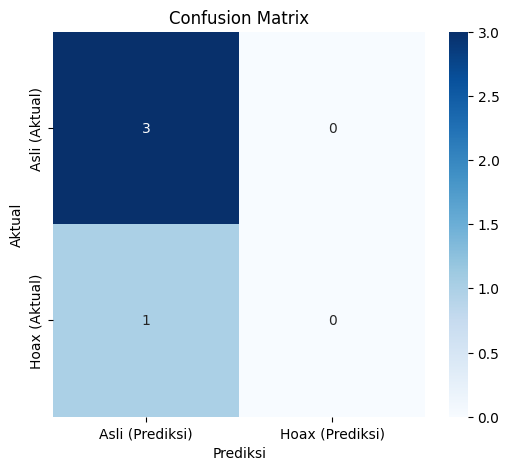

In [14]:
print("\n--- Evaluasi pada Data Testing ---")
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Prediksi pada data testing
y_pred_prob = model.predict(X_test)
# Konversi probabilitas ke kelas biner (0 atau 1) dengan threshold 0.5
y_pred = (y_pred_prob > 0.5).astype(int)

print("\n--- Classification Report ---")
# Menampilkan metrik kinerja seperti Presisi, Recall, F1-Score
print(classification_report(y_test, y_pred, target_names=['Asli (0)', 'Hoax (1)']))

print("\n--- Confusion Matrix ---")
# Menampilkan Confusion Matrix untuk visualisasi kinerja klasifikasi
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Asli (Prediksi)', 'Hoax (Prediksi)'],
            yticklabels=['Asli (Aktual)', 'Hoax (Aktual)'])
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.title('Confusion Matrix')
plt.show()

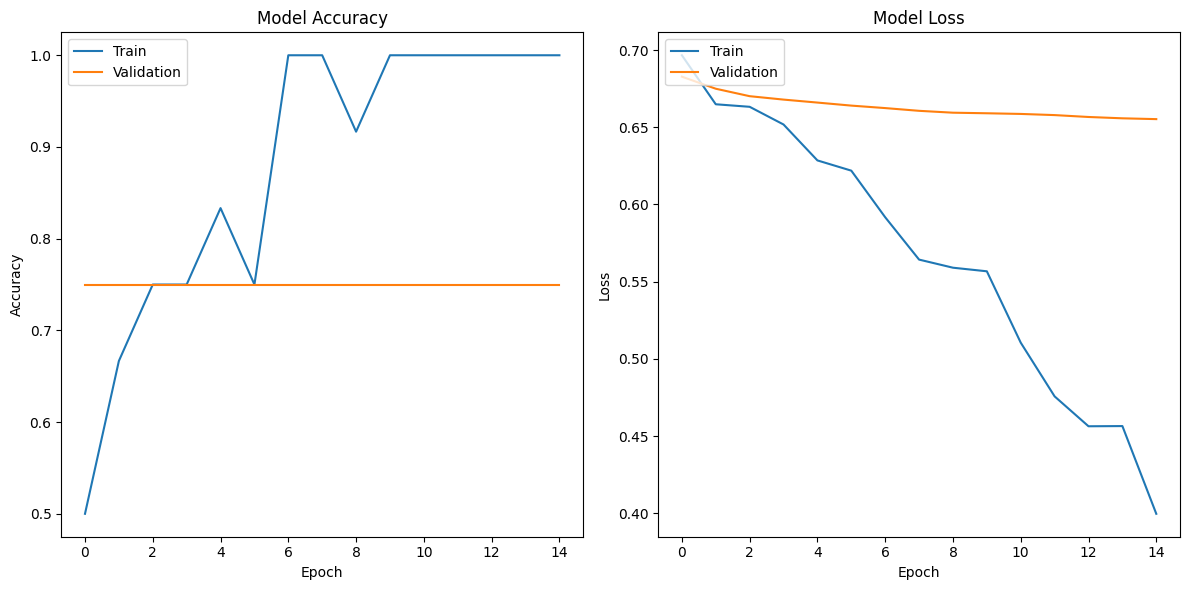

In [15]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1) # 1 baris, 2 kolom, plot pertama
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2) # 1 baris, 2 kolom, plot kedua
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout() # Mengatur layout agar tidak tumpang tindih
plt.show()

In [16]:
print("\n--- Contoh Prediksi Teks Baru ---")

def predict_hoax_or_not(text_input):
    # Pra-pemrosesan teks input
    sequence = tokenizer.texts_to_sequences([text_input])
    padded = pad_sequences(sequence, maxlen=max_length, padding=padding_type, truncating=trunc_type)

    # Melakukan prediksi
    prediction = model.predict(padded)[0][0]

    # Menentukan hasil berdasarkan threshold
    if prediction > 0.5:
        result = "HOAX"
        prob_hoax = prediction * 100
        prob_asli = (1 - prediction) * 100
    else:
        result = "ASLI"
        prob_hoax = prediction * 100
        prob_asli = (1 - prediction) * 100

    print(f"\nKalimat: '{text_input}'")
    print(f"Prediksi: Ini kemungkinan {result}")
    print(f"Probabilitas Hoax: {prob_hoax:.2f}%")
    print(f"Probabilitas Asli: {prob_asli:.2f}%")

# Coba beberapa contoh
predict_hoax_or_not("Pemerintah mengumumkan kenaikan harga BBM mulai besok pagi.")
predict_hoax_or_not("Seorang nenek berusia 150 tahun ditemukan masih hidup dan sehat di hutan.")
predict_hoax_or_not("BNPB melaporkan kondisi terkini korban banjir di Sumatera Barat.")
predict_hoax_or_not("Para ilmuwan mengklaim menemukan bukti kehidupan di planet Mars.")
predict_hoax_or_not("Berita: Jokowi akan menjadi raja dunia dalam waktu dekat.")
predict_hoax_or_not("Fakta: Indeks Harga Saham Gabungan (IHSG) hari ini ditutup menguat.")


--- Contoh Prediksi Teks Baru ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step

Kalimat: 'Pemerintah mengumumkan kenaikan harga BBM mulai besok pagi.'
Prediksi: Ini kemungkinan ASLI
Probabilitas Hoax: 46.93%
Probabilitas Asli: 53.07%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step

Kalimat: 'Seorang nenek berusia 150 tahun ditemukan masih hidup dan sehat di hutan.'
Prediksi: Ini kemungkinan ASLI
Probabilitas Hoax: 45.47%
Probabilitas Asli: 54.53%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step

Kalimat: 'BNPB melaporkan kondisi terkini korban banjir di Sumatera Barat.'
Prediksi: Ini kemungkinan ASLI
Probabilitas Hoax: 45.33%
Probabilitas Asli: 54.67%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step

Kalimat: 'Para ilmuwan mengklaim menemukan bukti kehidupan di planet Mars.'
Prediksi: Ini kemungkinan ASLI
Probabilitas Hoax: 43.93%
Probabilitas Asli: 56.07%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step

Kalimat: 'Berita: Jokowi akan menjadi raja dunia dalam waktu dekat.'
Prediksi: Ini kemungkinan ASLI
Probabilitas Hoax: 45.56%